<a href="https://colab.research.google.com/github/SahelKherad/3-story-benchmark-transformer/blob/main/09_04(2_sensor_9_state_(splittimeSeries%3Ewindow).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1094]:
import os
import scipy.io
from scipy.io.matlab._mio5_params import mat_struct
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [1095]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1096]:
!ls "/content/drive/My Drive/ASCE"

shm01a.mat  shm03a.mat	shm05a.mat  shm07a.mat	shm09a.mat
shm02a.mat  shm04a.mat	shm06a.mat  shm08a.mat


In [1097]:
def load_mat(path):
    mat = scipy.io.loadmat(path, squeeze_me=True, struct_as_record=False)
    raw = mat.get('dasy')
    if isinstance(raw, mat_struct):
        channels = []
        for f in raw._fieldnames:
            arr = getattr(raw, f)
            channels.append(np.asarray(arr).reshape(-1))
        data = np.stack(channels, axis=1)  # (n_samples, n_channels)
    else:
        raise ValueError("Unexpected MAT structure. 'dasy' not a struct.")
    return data  # float64 by default

base_dir = '/content/drive/MyDrive/ASCE/'
state_files = {
    1: 'shm01a.mat', 2: 'shm02a.mat', 3: 'shm03a.mat',
    4: 'shm04a.mat', 5: 'shm05a.mat', 6: 'shm06a.mat',
    7: 'shm07a.mat', 8: 'shm08a.mat', 9: 'shm09a.mat',
}
# label_to_class_id: 1..9 -> 0..8
label_to_cid = {lab: i for i, lab in enumerate(sorted(state_files.keys()))}

scenario_data = {}   # cid -> np.ndarray [N, C]
for lab, fname in state_files.items():
    x = load_mat(os.path.join(base_dir, fname)).astype(np.float32)
    scenario_data[label_to_cid[lab]] = x
print(scenario_data[0][:,:].shape)
print(scenario_data[0][:,4].shape)
print(scenario_data[4][:,4].shape)
    # print(fname, x.shape)

(60000, 16)
(60000,)
(60000,)


In [1098]:
# 4) Choose the 5 scenarios and the 4 sensors you care about
chosen_scenario = {
    "healthy": 0,    # shm01a.mat
    "dam1":    1,    # shm02a.mat
    "dam2":    2,    # shm03a.mat
    "dam3":    3,    # shm04a.mat
    "dam4":    4,    # shm05a.mat
    "dam5":    5,    # shm06a.mat
    "dam6":    6,    # shm07a.mat
    "dam7":    7,    # shm08a.mat
    "dam8":    8,    # shm09a.mat
   }
sensor_cols = [3,4,5,6,7,8,9,10,11,12,13,14]


In [1099]:
win = 256
stride = 256

In [1100]:
def select_sensors(arr, cols):
  return arr[:, cols]

In [1101]:
# sensor1=10000*select_sensors(scenario_data[0], sensor_cols)
# sensor2=10000*select_sensors(scenario_data[1], sensor_cols)
# print(sensor1)
# print(sensor2)

In [1102]:
def split_time_based(X, train_ratio=0.6, val_ratio=0.2):
    n = len(X)
    m = int(train_ratio * n)
    l = int(val_ratio * n)
    train = X[:m]
    val   = X[m:m+l]
    test  = X[m+l:]
    return train, val, test

def build_split(scenario_data, chosen_scenario, sensor_cols):
  splits = {}
  for name, cid in chosen_scenario.items():
    # print(name, cid)
    data = select_sensors(scenario_data[cid], sensor_cols)
    train, val, test = split_time_based(data, train_ratio = 0.6, val_ratio = 0.2)
    splits[name] = (train, val, test)
  return splits


In [1103]:
splits = build_split(scenario_data, chosen_scenario, sensor_cols)

In [1104]:
train_0, val_0, test_0 = splits['healthy']
train_1, val_1, test_1 = splits['dam1']
train_2, val_2, test_2 = splits['dam2']
train_3, val_3, test_3 = splits['dam3']
train_4, val_4, test_4 = splits['dam4']
train_5, val_5, test_5 = splits['dam5']
train_6, val_6, test_6 = splits['dam6']
train_7, val_7, test_7 = splits['dam7']
train_8, val_8, test_8 = splits['dam8']

print((train_0.shape, val_0.shape, test_0.shape))
print((train_1.shape, val_1.shape, test_1.shape))
print((train_2.shape, val_2.shape, test_2.shape))
print((train_3.shape, val_3.shape, test_3.shape))
print((train_4.shape, val_4.shape, test_4.shape))
print((train_5.shape, val_5.shape, test_5.shape))
print((train_6.shape, val_6.shape, test_6.shape))
print((train_7.shape, val_7.shape, test_7.shape))
print((train_8.shape, val_8.shape, test_8.shape))

((36000, 12), (12000, 12), (12000, 12))
((36000, 12), (12000, 12), (12000, 12))
((36000, 12), (12000, 12), (12000, 12))
((36000, 12), (12000, 12), (12000, 12))
((36000, 12), (12000, 12), (12000, 12))
((27340, 12), (9113, 12), (9115, 12))
((108000, 12), (36000, 12), (36000, 12))
((108000, 12), (36000, 12), (36000, 12))
((108000, 12), (36000, 12), (36000, 12))


In [1105]:
# splits['healthy']

In [1106]:
# splits['dam1']

In [1107]:
# con = np.stack([train_0, train_1], axis=0)
# print(con)
# mu = con. mean(axis =(0,1), keepdims = True)
# print(mu)

In [1108]:
con = np.concatenate([train_0, train_1, train_2, train_3, train_4, train_5, train_6, train_7, train_8], axis=0)
print(con.shape)
mu = con. mean(axis =(0), keepdims = True)
print(mu.shape)
print(mu)
std = con.std(axis = (0), keepdims = True)+ 1e-6

(531340, 12)
(1, 12)
[[-1.5940368e-03 -4.5940842e-04  1.6806051e-04  1.5449510e-03
  -1.1416012e-03  1.2914694e-04  1.9678171e-03  4.2890679e-05
   5.2146864e-04 -5.9852621e-04  1.9527158e-04 -2.1243591e-03]]


In [1109]:
# def z_score(data, mu,std):
#   return (data - mu) / std

In [1110]:
# train_0 = z_score(train_0, mu, std)
# val_0 = z_score(val_0, mu, std)
# test_0 = z_score(test_0, mu, std)

# train_1 = z_score(train_1, mu, std)
# val_1 = z_score(val_1, mu, std)
# test_1 = z_score(test_1, mu, std)

# train_2 = z_score(train_2, mu, std)
# val_2 = z_score(val_2, mu, std)
# test_2 = z_score(test_2, mu, std)

# train_3 = z_score(train_3, mu, std)
# val_3 = z_score(val_3, mu, std)
# test_3 = z_score(test_3, mu, std)

# train_4 = z_score(train_4, mu, std)
# val_4 = z_score(val_4, mu, std)
# test_4 = z_score(test_4, mu, std)

# train_5 = z_score(train_5, mu, std)
# val_5 = z_score(val_5, mu, std)
# test_5 = z_score(test_5, mu, std)

# train_6 = z_score(train_6, mu, std)
# val_6 = z_score(val_6, mu, std)
# test_6 = z_score(test_6, mu, std)

# train_7 = z_score(train_7, mu, std)
# val_7 = z_score(val_7, mu, std)
# test_7 = z_score(test_7, mu, std)

# train_8 = z_score(train_8, mu, std)
# val_8 = z_score(val_8, mu, std)
# test_8 = z_score(test_8, mu, std)

In [1111]:
# train_0

In [1112]:
def window_1d(x, L=128, stride=128):
    N = len(x)
    if N < L:
        return np.empty((0, L), dtype=x.dtype)
    n = (N - L) // stride + 1
    idxs = np.arange(L)[None, :] + stride * np.arange(n)[:, None]
    return x[idxs]


# tr_0 = window_multichan(splits['healthy'],win,stride)
tr_0 = window_1d(train_0, win , stride)
va_0 = window_1d(val_0  , win , stride)
te_0 = window_1d(test_0 , win , stride)

tr_1 = window_1d(train_1 , win, stride)
va_1 = window_1d(val_1   , win, stride)
te_1 = window_1d(test_1  , win, stride)

tr_2 = window_1d(train_2 , win, stride)
va_2 = window_1d(val_2   , win, stride)
te_2 = window_1d(test_2  , win, stride)

tr_3 = window_1d(train_3 , win, stride)
va_3 = window_1d(val_3   , win, stride)
te_3 = window_1d(test_3  , win, stride)

tr_4 = window_1d(train_4 , win, stride)
va_4 = window_1d(val_4   , win, stride)
te_4 = window_1d(test_4  , win, stride)

tr_5 = window_1d(train_5 , win, stride)
va_5 = window_1d(val_5   , win, stride)
te_5 = window_1d(test_5  , win, stride)

tr_6 = window_1d(train_6 , win, stride)
va_6 = window_1d(val_6   , win, stride)
te_6 = window_1d(test_6  , win, stride)

tr_7 = window_1d(train_7 , win, stride)
va_7 = window_1d(val_7   , win, stride)
te_7 = window_1d(test_7  , win, stride)

tr_8 = window_1d(train_8 , win, stride)
va_8 = window_1d(val_8   , win, stride)
te_8 = window_1d(test_8  , win, stride)

tr_0.shape, tr_1.shape, tr_2.shape, tr_3.shape, tr_4.shape, tr_5.shape, tr_6.shape, tr_7.shape, tr_8.shape


((140, 256, 12),
 (140, 256, 12),
 (140, 256, 12),
 (140, 256, 12),
 (140, 256, 12),
 (106, 256, 12),
 (421, 256, 12),
 (421, 256, 12),
 (421, 256, 12))

In [1113]:
tr_0.shape

(140, 256, 12)

In [1114]:
# tr_0, va_0, te_0

In [1115]:
# tr_1, va_1, te_1

In [1116]:
# X_train = np.concatenate([tr_0, tr_1], axis=0)
# print(X_train.shape)
# X_train

In [1117]:
X_train = np.concatenate([tr_0, tr_1, tr_2, tr_3, tr_4, tr_5, tr_6, tr_7, tr_8], axis=0)
X_val   = np.concatenate([va_0, va_1, va_2, va_3, va_4, va_5, va_6, va_7, va_8], axis=0)
X_test  = np.concatenate([te_0, te_1, te_2, te_3, te_4, te_5, te_6, te_7, te_8], axis=0)

y_train = np.concatenate([
    np.full(len(tr_0), 0),
    np.full(len(tr_1), 1),
    np.full(len(tr_2), 2),
    np.full(len(tr_3), 3),
    np.full(len(tr_4), 4),
    np.full(len(tr_5), 5),
    np.full(len(tr_6), 6),
    np.full(len(tr_7), 7),
    np.full(len(tr_8), 8),
], axis=0)

y_val = np.concatenate([
    np.full(len(va_0), 0),
    np.full(len(va_1), 1),
    np.full(len(va_2), 2),
    np.full(len(va_3), 3),
    np.full(len(va_4), 4),
    np.full(len(va_5), 5),
    np.full(len(va_6), 6),
    np.full(len(va_7), 7),
    np.full(len(va_8), 8),
], axis=0)

y_test = np.concatenate([
    np.full(len(te_0), 0),
    np.full(len(te_1), 1),
    np.full(len(te_2), 2),
    np.full(len(te_3), 3),
    np.full(len(te_4), 4),
    np.full(len(te_5), 5),
    np.full(len(te_6), 6),
    np.full(len(te_7), 7),
    np.full(len(te_8), 8),
], axis=0)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2069, 256, 12) (685, 256, 12) (685, 256, 12)
(2069,) (685,) (685,)


In [1118]:
rng = np.random.default_rng(42)
idx = rng.permutation(len(X_train))
X_train = X_train[idx]
y_train = y_train[idx]

In [1119]:
X_train = torch.from_numpy(X_train).float()
X_val   = torch.from_numpy(X_val).float()
X_test  = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_val   = torch.from_numpy(y_val).long()
y_test  = torch.from_numpy(y_test).long()

In [1120]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

torch.Size([2069, 256, 12]) torch.Size([2069])
torch.Size([685, 256, 12]) torch.Size([685])
torch.Size([685, 256, 12]) torch.Size([685])


In [1121]:
class SeqDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X.float()  # [N, seq_len, 1]
        self.y = y.long()  # [N]
    def __len__(self): return self.y.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

train_ds = SeqDataset(X_train, y_train)
print(X_train.shape)
# print(train_ds[0])
# print(train_ds[1])
# print(train_ds[2])
val_ds   = SeqDataset(X_val,   y_val)
test_ds  = SeqDataset(X_test,  y_test)

torch.Size([2069, 256, 12])


In [1122]:
# 6) DataLoaders: shuffle only the training set
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

In [1123]:
with torch.no_grad():
    ys_tr = torch.cat([yb.view(-1) for _, yb in train_loader], dim=0).cpu()
    ys_va = torch.cat([yb.view(-1) for _, yb in val_loader], dim=0).cpu()
    ys_te = torch.cat([yb.view(-1) for _, yb in test_loader], dim=0).cpu()


print("train label set/counts:", ys_tr.unique(return_counts=True))
print("val   label set/counts:", ys_va.unique(return_counts=True))
print("test  label set/counts:", ys_te.unique(return_counts=True))
print("train min/max:", ys_tr.min().item(), ys_tr.max().item())
print("val   min/max:", ys_va.min().item(), ys_va.max().item())

train label set/counts: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([140, 140, 140, 140, 140, 106, 421, 421, 421]))
val   label set/counts: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([ 46,  46,  46,  46,  46,  35, 140, 140, 140]))
test  label set/counts: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([ 46,  46,  46,  46,  46,  35, 140, 140, 140]))
train min/max: 0 8
val   min/max: 0 8


In [1124]:
class LearnablePositionalEncoding(nn.Module):
    """
    Learnable positional encoding added to token embeddings.
    Shape stored: [1, max_len, d_model]
    """
    def __init__(self, d_model: int, max_len: int):
        super().__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))
        print(self.pe)
        nn.init.trunc_normal_(self.pe, std=0.02)

    def forward(self, x):
        # x: [B, T, d_model]
        T = x.size(1)
        return x + self.pe[:, :T, :]

In [1125]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, d_model=256, nhead=4, num_layers=3, d_ff=256, seq_len= X_train.shape[1], num_classes=3, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(12, d_model)                            # project feature_dim=1 -> d_model
        self.pos = LearnablePositionalEncoding(d_model, seq_len)    # learnable PE
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=d_ff, dropout=dropout,
            batch_first=True                                        # so we keep [B, T, d]
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: [B, T, 1]
        x = self.inp(x)                  # [B, T, d]
        x = self.pos(x)                  # add learnable PE
        x = self.encoder(x)              # [B, T, d]
        x = self.norm(x)
        x = x.mean(dim=1)                # mean pool over time

        logits = self.head(x)            # [B, C]
        return logits

In [1126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = X_train.shape[1]
num_classes = 9
model = TimeSeriesTransformer(
    d_model=16,
    nhead=2,
    num_layers=4,
    d_ff=16,
    seq_len=seq_len ,
    num_classes=9,
    dropout=0.1).to(device)

Parameter containing:
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], requires_grad=True)


In [1127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device) # Move the model to the selected device

Using device: cuda


TimeSeriesTransformer(
  (inp): Linear(in_features=12, out_features=16, bias=True)
  (pos): LearnablePositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=16, out_features=9, bias=True)
)

In [1128]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

loss_fn = nn.CrossEntropyLoss()

In [1129]:
num_epochs = 200
tr_losses, tr_accs, val_losses, val_accs = [], [], [], []

for epoch in range(num_epochs):
     model.train()
     total_loss, total_samples, correct_predictions = 0, 0, 0
     for xb, yb in train_loader:
        xb , yb = xb.to(device) , yb.to(device).long()
        optimizer.zero_grad()
        output = model(xb)
        # print('output',output)
        # print('max',torch.max(output, 1))
        # print('yb',yb)

        loss = loss_fn(output , yb)
        # print('loss',loss)
        # optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        # print(loss.item())
        # print(xb.size(0))
        # print('total:',total_loss)

        # Calculate accuracy
        pred = output.argmax(dim=1) # the index of the maximum value for each column
        # print('p',predicted)
        # print('real',yb)
        total_samples += xb.size(0)
        # print(total_samples)
        correct_predictions += (pred == yb).sum().item()
        # print(correct_predictions)

     epoch_loss = total_loss / total_samples
     epoch_accuracy = correct_predictions / total_samples
     tr_losses.append(epoch_loss)
     tr_accs.append(epoch_accuracy)

    #  print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f}")

     model.eval()
     val_correct_predictions , val_total_samples , val_total_loss = 0 , 0 , 0

     with torch.no_grad():
          for xb, yb in val_loader:
              xb, yb = xb.to(device), yb.to(device).long()
              output = model(xb)
              val_loss = loss_fn(output,yb)
              val_total_loss += val_loss.item() * xb.size(0)
              pred = output.argmax(dim=1)
              val_total_samples += xb.size(0)
              val_correct_predictions += (pred == yb).sum().item()

     val_epoch_loss = val_total_loss / val_total_samples
     val_epoch_accuracy = val_correct_predictions / val_total_samples
    #  print(    f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")
     val_losses.append(val_epoch_loss)
     val_accs.append(val_epoch_accuracy)
     # 3) Step the scheduler once per epoch, after validation
    #  scheduler.step()

     # Optional: print current lr to confirm schedule
     current_lr = optimizer.param_groups[0]["lr"]
     print(f"Epoch {epoch+1}/{num_epochs}: " f"Train Loss: {epoch_loss:.4f}, "f"Train Accuracy: {epoch_accuracy:.4f} | "f"Validation Loss: {val_epoch_loss:.4f}, "f"Validation Accuracy: {val_epoch_accuracy:.4f}\n")


Epoch 1/200: Train Loss: 2.1378, Train Accuracy: 0.1924 | Validation Loss: 2.0419, Validation Accuracy: 0.2044

Epoch 2/200: Train Loss: 2.0422, Train Accuracy: 0.2001 | Validation Loss: 2.0332, Validation Accuracy: 0.2044

Epoch 3/200: Train Loss: 2.0389, Train Accuracy: 0.1943 | Validation Loss: 2.0338, Validation Accuracy: 0.2044

Epoch 4/200: Train Loss: 2.0394, Train Accuracy: 0.1880 | Validation Loss: 2.0320, Validation Accuracy: 0.2044

Epoch 5/200: Train Loss: 2.0406, Train Accuracy: 0.2011 | Validation Loss: 2.0323, Validation Accuracy: 0.2044

Epoch 6/200: Train Loss: 2.0395, Train Accuracy: 0.2054 | Validation Loss: 2.0328, Validation Accuracy: 0.2044

Epoch 7/200: Train Loss: 2.0366, Train Accuracy: 0.2156 | Validation Loss: 2.0370, Validation Accuracy: 0.2044

Epoch 8/200: Train Loss: 2.0378, Train Accuracy: 0.2040 | Validation Loss: 2.0317, Validation Accuracy: 0.2044

Epoch 9/200: Train Loss: 2.0376, Train Accuracy: 0.2030 | Validation Loss: 2.0316, Validation Accuracy: 

In [1130]:
import torch.nn.functional as F
val_probs = []
val_true  = []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        val_probs.append(F.softmax(out, dim=1).max(1).values.cpu())
        val_true.append(yb)
val_probs = torch.cat(val_probs)
print('Val avg max-softmax:', val_probs.mean().item())

Val avg max-softmax: 0.8241780400276184


In [1131]:
from sklearn.metrics import confusion_matrix
import numpy as np
all_pred, all_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb.to(device))
        all_pred.append(out.argmax(1).cpu().numpy())
        all_true.append(yb.numpy())
cm = confusion_matrix(np.concatenate(all_true), np.concatenate(all_pred))
print(cm)

[[ 46   0   0   0   0   0   0   0   0]
 [  0  46   0   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0   0]
 [  0   0   0  46   0   0   0   0   0]
 [ 23   0   0   0  23   0   0   0   0]
 [  0   0   0   0   0  35   0   0   0]
 [  0   0   0   0   0   0 140   0   0]
 [  0   0   0   0   0   0   0 140   0]
 [  0   0   0   0   0   0   0 140   0]]


In [1132]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

model.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        pred = out.argmax(dim=1).cpu().numpy()
        all_pred.append(pred)
        all_true.append(yb.numpy())

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Accuracy
acc = accuracy_score(y_true, y_pred)

# Precision, recall, F1 (macro average over 9 classes)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

print("Accuracy:", acc)
print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1 (macro):", f1)


[[ 46   0   0   0   0   0   0   0   0]
 [  0  46   0   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0   0]
 [  0   0   0  46   0   0   0   0   0]
 [ 31   0   0   0  15   0   0   0   0]
 [  0   0   0   0   0  35   0   0   0]
 [  0   0   0   0   0   0 140   0   0]
 [  0   0   0   0   0   0   0 140   0]
 [  0   0   0   0   0   0   0 140   0]]
Accuracy: 0.7503649635036497
Precision (macro): 0.7886002886002886
Recall (macro): 0.8140096618357489
F1 (macro): 0.7673819361144432


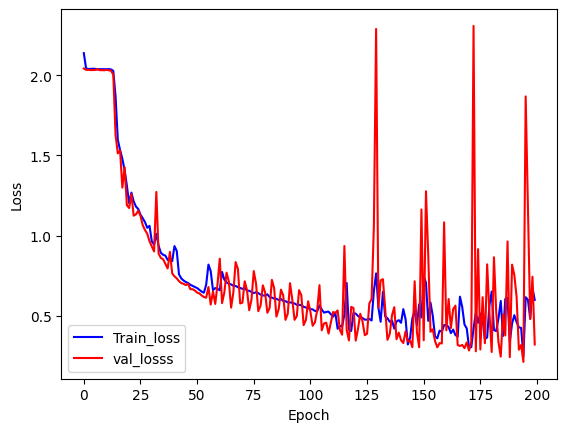

In [1133]:
epoch = np.arange(0,num_epochs , 1)
import matplotlib.pyplot as plt

plt.plot(epoch, tr_losses , label="Train_loss", c='b')
plt.plot(epoch, val_losses, label="val_losss", c='r')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [1134]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

model.eval()
all_true = []
all_pred = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        pred = out.argmax(dim=1).cpu().numpy()
        all_pred.append(pred)
        all_true.append(yb.numpy())

y_true = np.concatenate(all_true)
y_pred = np.concatenate(all_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Accuracy
acc = accuracy_score(y_true, y_pred)

# Precision, recall, F1 (macro average over 9 classes)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

print("Accuracy:", acc)
print("Precision (macro):", prec)
print("Recall (macro):", rec)
print("F1 (macro):", f1)


[[ 46   0   0   0   0   0   0   0   0]
 [  0  46   0   0   0   0   0   0   0]
 [  0   0  46   0   0   0   0   0   0]
 [  0   0   0  46   0   0   0   0   0]
 [ 31   0   0   0  15   0   0   0   0]
 [  0   0   0   0   0  35   0   0   0]
 [  0   0   0   0   0   0 140   0   0]
 [  0   0   0   0   0   0   0 140   0]
 [  0   0   0   0   0   0   0 140   0]]
Accuracy: 0.7503649635036497
Precision (macro): 0.7886002886002886
Recall (macro): 0.8140096618357489
F1 (macro): 0.7673819361144432


In [1135]:
prec_cls, rec_cls, f1_cls, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)


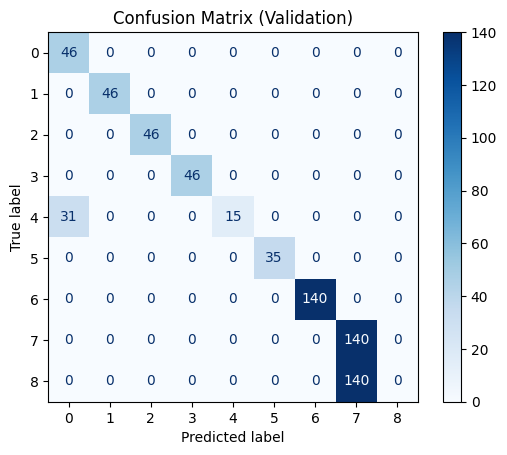

In [1136]:
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_true, y_pred, y_score = [], [], []
model.eval()

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device).long()   # targets should be int for CE
        logits = model(xb)                             # [B, num_classes]

        # 1) Probability of class 1
        # For multiclass ROC/PR, you'd typically get scores for each class
        probs  = torch.softmax(logits, dim=1)          # [B, num_classes]
        # y_score is currently only storing probabilities for class 1
        # To plot multiclass ROC/PR, you'd need probabilities for all classes
        # and adapt the plotting functions or use a one-vs-rest approach.
        score1 = probs[:, 1]                           # [B]

        # 2) Predicted class index
        preds  = logits.argmax(dim=1)                  # [B]

        # Save results
        y_true.extend(yb.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
        y_score.extend(score1.cpu().tolist()) # Storing scores for class 1 only

# 1) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()

# The following lines are commented out because they are designed for binary classification
# and will raise a ValueError for multiclass targets (0, 1, 2).
# To plot ROC or Precision-Recall for multiclass, a one-vs-rest strategy is typically used,
# which would involve binarizing y_true for each class and providing corresponding class probabilities.

# # 2) ROC
# RocCurveDisplay.from_predictions(y_true, y_score)
# plt.title("ROC Curve (Validation)")
# plt.show()

# # 3) Precision–Recall
# PrecisionRecallDisplay.from_predictions(y_true, y_score)
# plt.title("Precision–Recall Curve (Validation)")
# plt.show()

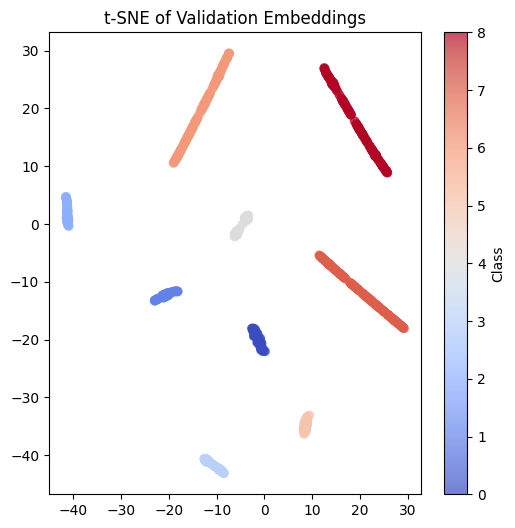

In [1137]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

model.eval()
all_embeds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        # Pass through encoder only (skip classifier head)
        embeds = model.encoder(model.inp(xb) + model.pos(model.inp(xb)))
        embeds = embeds.mean(dim=1)                # [B, d_model]

        all_embeds.append(embeds.cpu())
        all_labels.append(yb.cpu())

# Concatenate all batches
all_embeds = torch.cat(all_embeds, dim=0).numpy()
all_labels = torch.cat(all_labels, dim=0).numpy()

# Run t-SNE
X_2d = TSNE(n_components=2, random_state=42).fit_transform(all_embeds)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=all_labels, cmap="coolwarm", alpha=0.7)
plt.colorbar(label="Class")
plt.title("t-SNE of Validation Embeddings")
plt.show()